In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import numpy as np
from tqdm import tqdm

from propinf.attack.attack_utils import AttackUtil
import propinf.data.ModifiedDatasets as data
from sklearn.model_selection import train_test_split

# import warnings
# warnings.filterwarnings("ignore")

# cat_columns, cont_columns = data.get_census_columns()
cat_columns, cont_columns = data.get_adult_columns()
# cat_columns, cont_columns = data.get_market_columns()
# cat_columns, cont_columns = data.get_heart_columns()

dataset = "adult"
df_train, df_test = data.load_data(dataset, one_hot=False)

In [4]:
categories = ['sex', 'marital-status']
target_attributes = [' Male', ' Divorced']
sub_categories = ['race']
sub_attributes = [' Black']

t0 = 0.01
t1 = 0.05

n_trials = 1
pois_list = [0.01]
models_list = [[]]
freq_list = [0.10]
n_queries = [100, 500, 1000, 1500, 2000]

In [5]:
df_train['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

# Our work

**In order to increase the size of target dataset, need to change code in ModifiedDataset.py**

In [6]:
num_query_trials = 10
avg_success = {}
avg_acc = {}
avg_prec = {}
avg_recall = {}
avg_f1 = {}

mu0_list = [0.0] * len(pois_list)
var0_list = [0.0] * len(pois_list)
mu1_list = [0.0] * len(pois_list)
var1_list = [0.0] * len(pois_list)

for abl_ind, nq in enumerate(tqdm(freq_list, desc="Ablation List")):

    # Done to keep track of acc metrics, change df_test to df_test_subset
    # df_test_subset, df_cv = train_test_split(df_test, test_size=0.20, random_state=21)
    # df_cv = data.generate_subpopulation(df_cv, categories=categories, target_attributes=target_attributes)
    # print(df_cv)

    attack_util = AttackUtil(
        target_model_layers=[32, 16],
        df_train=df_train,
        df_test=df_test,
        cat_columns=cat_columns,
    )

    for pois_idx, user_percent in enumerate(tqdm(pois_list)):

        # avg_acc[user_percent,aidx] = 0.0
        # avg_prec[user_percent,aidx] = 0.0
        # avg_recall[user_percent,aidx] = 0.0
        # avg_f1[user_percent,aidx] = 0.0
        avg_success[user_percent, abl_ind] = 0.0

        attack_util.set_attack_hyperparameters(
            categories=categories,
            target_attributes=target_attributes,
            sub_categories=sub_categories,
            sub_attributes=sub_attributes,
            subproperty_sampling=False,
            allow_custom_freq=False,
            label_freq=0.7,
            poison_percent=user_percent,
            poison_class=1,
            k=None,
            t0=t0,
            t1=t1,
            variance_adjustment=1.0,
            middle="median",
            num_queries=600,
            pois_random_seed=21,
            num_target_models=5,
            ntarget_samples=1500,
            nsub_samples=1500,
            allow_subsampling=False,
            allow_target_subsampling=False,
        )

        attack_util.set_shadow_model_hyperparameters(
            device="cpu",
            num_workers=1,
            batch_size=1024,
            layer_sizes=[32, 16],
            verbose=False,
            mini_verbose=False,
            epochs=15,
            alterdata_list=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
            # FTepochs=5,
            tol=1e-6,
        )

        for i in range(n_trials):

            attack_util.generate_datasets()

            attack_util.train_and_poison_target(need_metrics=False)
            # acc, prec, recall, f1 =  attack_util.train_and_poison_target(need_metrics=True, df_cv = df_cv)

            # start_time = time.time()
            (
                out_M0,
                out_M1,
                threshold,
                correct_trials,
            ) = attack_util.property_inference_categorical(
                num_shadow_models=4,
                query_trials=num_query_trials,
                query_selection="random",
                distinguishing_test="median",
            )
            # end_time = time.time()
            # print(end_time-start_time)

            # avg_acc[user_percent, aidx] = avg_acc[user_percent, aidx] + acc/n_trials
            # avg_prec[user_percent, aidx] = avg_prec[user_percent, aidx] + prec/n_trials
            # avg_recall[user_percent, aidx] = avg_recall[user_percent, aidx] + recall/n_trials
            # avg_f1[user_percent, aidx] = avg_f1[user_percent, aidx] + f1/n_trials
            avg_success[user_percent, abl_ind] = (
                avg_success[user_percent, abl_ind] + correct_trials / n_trials
            )

            # Compute mean and variance of ovserved logits distributions
            mu0_list[pois_idx], mu1_list[pois_idx] = (
                mu0_list[pois_idx] + np.mean(out_M0) / n_trials,
                mu1_list[pois_idx] + np.mean(out_M1) / n_trials,
            )
            var0_list[pois_idx], var1_list[pois_idx] = (
                var0_list[pois_idx] + np.var(out_M0) / n_trials,
                var1_list[pois_idx] + np.var(out_M1) / n_trials,
            )


Ablation List:   0%|          | 0/1 [00:00<?, ?it/s]

Before attempting to run the property inference attack, set hyperparameters using
        1. set_attack_hyperparameters()
        2. set_model_hyperparameters()


/Users/gio/projects/research/privacy/propinf_ft/propinf/data/ModifiedDatasets.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dp.loc[:, label] = poison_class


Oversampling test queries


Ablation List: 100%|██████████| 1/1 [02:09<00:00, 129.91s/it]


In [7]:
# df_cv

In [8]:
avg_acc, avg_prec, avg_recall, avg_f1

({}, {}, {}, {})

In [9]:
avg_success

{(0.01, 0): 1.0}

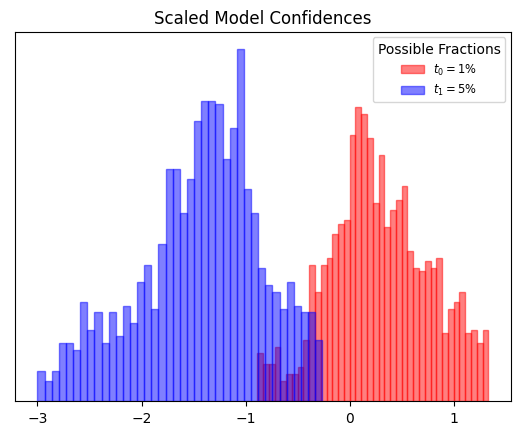

In [10]:
import matplotlib.pyplot as plt
plt.hist(out_M0, color="r", bins=40, alpha=0.5,label="$t_{0}=1\%$", edgecolor="r")
plt.hist(out_M1, color="b", bins= 40, alpha=0.5, label="$t_{1}=5\%$", edgecolor="b")
plt.legend(title = 'Possible Fractions',fontsize = 8.3)
plt.title(f"Scaled Model Confidences")
plt.yticks(())
# plt.savefig("SMC-3P.pdf")
plt.show()